# Activation Maximization in CNNs

<a href="https://colab.research.google.com/drive/1rypOHeIM8l1_oEzZVUhpaueqblYIS7Sw" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [Castle](https://github.com/Nkluge-correa/TeenyTinyCastle)

According to "_[The mythos of model interpretability](https://arxiv.org/pdf/1606.03490.pdf)_", these are the properties of an "interpretable model":

> A human can repeat ("simulatability") the computation process with a full understanding of the algorithm ("algorithmic transparency"), and every individual part of the model owns an intuitive explanation ("decomposability").

Explainable AI (XAI) is an approach to artificial intelligence that aims to achieve this level of interpretability. In it, we seek to create transparent, interpretable models that can provide human-understandable explanations for their decisions or predictions. Techniques from XAI can help us increase the transparency and accountability of AI systems by providing interpretable explanations for their behavior, which is particularly important in healthcare, finance, and law enforcement applications, where decisions made by AI models can significantly impact people's lives.

XAI (specifically in CV applications) has formed two major threads of response: **feature visualization** and **saliency mapping**. This notebook focuses on feature visualization techniques.

![image](https://christophm.github.io/interpretable-ml-book/images/cnn-features.png)

[Source](https://christophm.github.io/interpretable-ml-book/).

In this tutorial, we'll explore **Activation Maximization**. Activation maximization is a technique in machine learning used to understand and visualize the features a neural network learns. It involves optimizing an input image that maximizes the activation of a particular part of a neural network or its output. It can be a helpful tool for understanding and interpreting the behavior of CNNs. In simple terms, we are trying to answer:

> **_What is a neuron looking for? How does this affect the output? Can we explore how the network decides that a "Cat" is a "Cat"_?**

> For a comprehensive explanation of the limitations and difficulties related to activation maximization, we recommend "[Visualizing Higher-Layer Features of a Deep Network](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network)." For a complete guide on ML Explainability, we recommend "[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)".

This notebook will analyze the activation maximization of a pre-trained CNN  (MobileNetV2) available through the `TensorFlow` library. Let us get started by loading our pre-trained CNN.

In [1]:
import tensorflow as tf

# Import MobileNetV2 network with pre-trained weights (from being trained on the Imagnet dataset)
model = tf.keras.applications.MobileNetV2(
    input_shape=None,
    alpha=1.0,
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print("TensorFlow version:", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

model.summary()

14536120/14536120 [==============================] - 0s 0us/step
TensorFlow version: 2.15.0
Eager mode:  True
GPU is available
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                   

We have to use the right kind of input to stimulate our network. MobileNetV2 works with images of shapes 224, 224, 3. Then, let us start by creating a random picture to use as a black slate for our network.

Then, we will create a loss function to perform gradient updates on our image. In simple terms, instead of updating the parameters of our network concerning the loss function, we will update our image concerning how much a filter is activated.

In the following examples, we will create images that maximally activate the following classes:

- Egyptian Cat.
- Hair Spray.
- Electric Guitar.
- Zebra.

> **Note: Here is a link with the identification of the 1000 classes present in the ImageNet database: [IMAGENET 1000 Class List](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).**

Optimizing for class index: 285
Optimization completed!
Optimizing for class index: 585
Optimization completed!
Optimizing for class index: 546
Optimization completed!
Optimizing for class index: 340
Optimization completed!


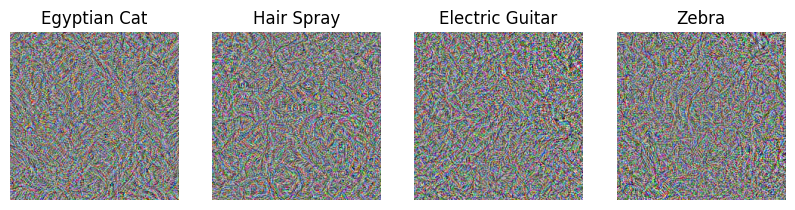

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.mobilenet import decode_predictions

# The dictionary of classes/targets we are using. Concerning these targets
# that we seek to optimize our initial images (which are just noise)
classes = {"Egyptian Cat" : 285,
            "Hair Spray": 585,
            "Electric Guitar": 546,
            "Zebra": 340}

# Function to generate optimized images for given classes
def generate_optimized_image(class_index):
    # Initialize the image with random noise
    noise = tf.Variable(tf.random.normal((1, 224, 224, 3), 0.0, 0.1))

    # One-hot encode the target class
    target_class = tf.one_hot([class_index], 1000, on_value=1.0, off_value=0.0, axis=None, dtype=tf.float32)

    # Use Adam optimizer
    opt = tf.optimizers.Adam(learning_rate=0.05)

    print(f"Optimizing for class index: {class_index}")

    # Optimization loop
    for step in range(1000): # 1000 steps of optimization with Adam
        with tf.GradientTape() as tape:
            # Calculate the loss as the L2 norm between model output and target class
            loss = tf.norm(model(noise) - target_class)
            grad = tape.gradient(loss, noise)
            opt.apply_gradients([(grad, noise)])

            # Clip image to ensure pixel values remain within valid range (-1.0, 1.0)
            noise.assign(tf.clip_by_value(noise, -1.0, 1.0))

    # Convert the optimized image to valid range (0, 1)
    optimized_image = np.clip((1.0 + noise.numpy()[0, :, :, :]) / 2.0, 0, 1)

    print("Optimization completed!")
    return optimized_image

# Generate optimized images for each class and store them in a list
optimized_images = [generate_optimized_image(class_index) for class_index in classes.values()]

# Plot the optimized images
plt.figure(figsize=(10, 5))
for i, (class_name, optimized_image) in enumerate(zip(classes.keys(), optimized_images)):
    plt.subplot(1, len(classes), i + 1)
    plt.imshow(optimized_image)
    plt.title(class_name)
    plt.axis('off')
plt.show()


Now that we have created images that maximally activate all the target classes (Egyptian Cat, Hair Spray, Electric guitar, and Zebra), we can look for ways that would explain why "_a cat is a cat_" for a CNN, since these images represent what the CNN is looking for.

These images are similar to Rorschach paintings. The human eye will naturally search for patterns, like cat ears and zebra stripes, to match the known output class with the produced image. However, CNNs have a different representation of how visual data related to a given class can be "understood, " making CNNs hard to interpret.

For example, [Polysemantic Neurons](https://distill.pub/2020/circuits/zoom-in/#claim-1-polysemantic) respond to multiple unrelated inputs (like a cat's ear and the front of a car) and defy the notion that these systems compartmentalize representations in a human-native, hierarchically separated, way.

<img src="https://distill.pub/2020/circuits/zoom-in/images/polysemantic.png" alt="An image of 4e:55: a polysemantic neuron which responds to cat faces, fronts of cars, and cat legs." width="600">

> **Above, we have an image of 4e:55: a polysemantic neuron that responds to cat faces, fronts of cars, and cat legs.**


Now, another thing we can do is to see how these synthetic images disrupt the classification of other photos. First, let us get a sample image from the [public domain](https://cdn.pixabay.com/photo/2020/11/26/11/48/cat-5778777_1280.jpg) and see how our classifier deals with it.

--2024-03-05 12:39:16--  https://cdn.pixabay.com/photo/2016/11/14/04/45/elephant-1822636_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362987 (354K) [binary/octet-stream]
Saving to: ‘elephant-1822636_1280.jpg’

elephant-1822636_12 100%[===================>] 354.48K  --.-KB/s    in 0.02s   

2024-03-05 12:39:16 (14.3 MB/s) - ‘elephant-1822636_1280.jpg’ saved [362987/362987]

Indian_elephant (Confidence: 45.88%)
tusker (Confidence: 10.73%)
African_elephant (Confidence: 5.03%)
geyser (Confidence: 2.53%)
hog (Confidence: 2.22%)


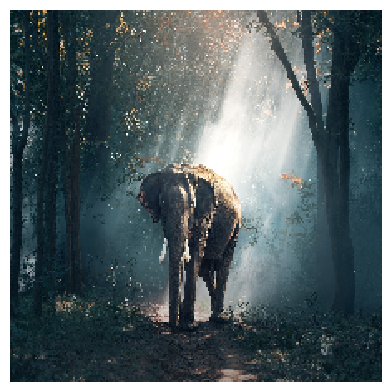

In [14]:
!wget https://cdn.pixabay.com/photo/2016/11/14/04/45/elephant-1822636_1280.jpg

img_path = r'./elephant-1822636_1280.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
img = tf.keras.utils.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

preds = model.predict(tf.constant(img),verbose=0)

top_5 = [
    f'{decode_predictions(preds)[0][i][1]} (Confidence: {decode_predictions(preds)[0][i][2] * 100 :.2f}%)' \
           for i in range(5)
        ]

for output in top_5:
    print(output)

plt.matshow(img[0])
plt.axis('off')
plt.show()

We can see that most of the probability mass of our classifier is located in "elephant-like" classes. However, if we add 30% of our artificially generated `Electric Guitar` image, we can alter this probability distribution substantially.

African_hunting_dog (Confidence: 4.66%)
Indian_elephant (Confidence: 3.66%)
tusker (Confidence: 3.56%)
red_wolf (Confidence: 2.81%)
dhole (Confidence: 2.21%)


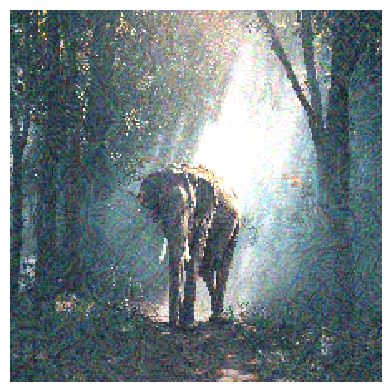

In [25]:
perturbed_cat = img[0] + optimized_images[2] * 0.3
perturbed_cat = np.expand_dims(perturbed_cat, axis=0)

preds = model.predict(tf.constant(perturbed_cat),verbose=0)

top_5 = [
    f'{decode_predictions(preds)[0][i][1]} (Confidence: {decode_predictions(preds)[0][i][2] * 100 :.2f}%)' \
           for i in range(5)
        ]

for output in top_5:
    print(output)

perturbed_cat = np.clip(perturbed_cat, 0, 1, out=perturbed_cat)
plt.matshow(perturbed_cat[0])
plt.axis('off')
plt.show()

Interpretability techniques like the one in this tutorial can help us better understand how `CNNs` perceive visual data and expose some of the vulnerabilities of computer vision algorithms trained via gradient-based learning methods.

This approach is the basic idea behind the creation of adversarial examples, i.e., perturbing inputs to hinder the behavior of an ML model. For more information on [Adversarial ML](https://en.wikipedia.org/wiki/Adversarial_machine_learning), you can check [our repository](https://github.com/Nkluge-correa/TeenyTinyCastle/tree/master/ML-Adversarial).

---

Return to the [Castle](https://github.com/Nkluge-correa/TeenyTinyCastle)